<a href="https://colab.research.google.com/github/darkar18/Baby-Cry-Audio-Classification/blob/master/Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import librosa
from torch.utils.data import random_split,Dataset
import soundfile as sf
import numpy as np
import librosa.display as dp
import librosa.filters
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.cuda.is_available()

True

In [4]:
DATA ="/content/drive/MyDrive/baby-cry/gveres donateacry-corpus master donateacry_corpus_cleaned_and_updated_data"
os.listdir(DATA)

['tired_uniform',
 'belly_pain_uniform',
 'discomfort_uniform',
 'burping_uniform',
 'hungry_uniform']

In [5]:
#creating a pandas dataset
data = pd.DataFrame(columns=["name","label"])
dirs = os.listdir(DATA)
for i in range(0,5) :
    label=i
    for _,_,f in os.walk(os.path.join(DATA,dirs[i])):
        for file in f:
            tuple = pd.DataFrame([{"name":os.path.join(dirs[i],file),"label":label}])
            data = pd.concat([data,tuple])

In [9]:
data

,name,label
0,tired_uniform/cut_06c4cfa2-7fa6-4fda-91a1-ea18...,0
0,tired_uniform/cut_03ADDCFB-354E-416D-BF32-260C...,0
0,tired_uniform/cut_06c4cfa2-7fa6-4fda-91a1-ea18...,0
0,tired_uniform/cut_06c4cfa2-7fa6-4fda-91a1-ea18...,0
0,tired_uniform/cut_7A22229D-06C2-4AAA-9674-DE5D...,0
...,...,...
0,hungry_uniform/cut_FF2CD2F6-404D-4626-8718-6E6...,4
0,hungry_uniform/cut_FF2CD2F6-404D-4626-8718-6E6...,4
0,hungry_uniform/cut_FF2CD2F6-404D-4626-8718-6E6...,4
0,hungry_uniform/cut_FF2CD2F6-404D-4626-8718-6E6...,4


In [7]:
audio = librosa.load(os.path.join(DATA,data.iloc[0]["name"]))

In [6]:
class AudioDataset(Dataset):
  def __init__(self,data=data,root=DATA,device="cuda:0"):
    self.root = root
    self.data = data
    self.device = device

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    filename  = os.path.join(self.root,self.data.iloc[index]["name"])
    label  = self.data.iloc[index]["label"]


    audio,sr = librosa.load(filename)
    mfcc = librosa.feature.mfcc(audio,n_mfcc=30)[:,:281]
    mfcc = torch.from_numpy(mfcc)
    mfcc.to(device=self.device)
    label = torch.tensor(label)
    label.to(device = self.device)
    # label = torch.Tensor(label)
    return mfcc,label




In [7]:
dataset = AudioDataset()

In [51]:
dataset.__getitem__(4)[1]

tensor(0)

In [8]:
from torch.utils.data import random_split
test_size = 0.2
test_l = int(test_size * len(dataset)) +1
train_l = int((1-test_size) * len(dataset) )
test_l,train_l,(test_l+train_l),len(dataset)
train_dataset, test_dataset = random_split(dataset,[train_l,test_l])
  

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [10]:
import torch.nn as nn
from torchvision.models import resnet34
import torch.optim as optim
from torchsummary import summary

def myresnet():
    resnet_model = resnet34(pretrained=True)
    resnet_model.fc = nn.Linear(512,5)
    resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet_model = resnet_model.to("cuda:0")
    return resnet_model

# summary(resnet_model,(1,30,281))
inputtensor = torch.rand(16,1,30,281).to("cuda:0")
# inputtensor = inputtensor.to(dml)
resnet_model = myresnet()
pred = resnet_model(inputtensor)
class_probs = torch.softmax(pred,dim = 0)
class_probs = torch.argmax(class_probs,dim=1)
class_probs

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

tensor([1, 3, 0, 3, 2, 0, 4, 2, 3, 4, 3, 2, 3, 0, 2, 3], device='cuda:0')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1


  5%|▌         | 1/20 [00:27<08:34, 27.07s/it]

loss: 0.0013717054389417171
---------------------------
Epoch 2


 10%|█         | 2/20 [00:55<08:24, 28.04s/it]

loss: 0.010305686853826046
---------------------------
Epoch 3


 15%|█▌        | 3/20 [01:27<08:21, 29.50s/it]

loss: 0.053990576416254044
---------------------------
Epoch 4


 20%|██        | 4/20 [01:54<07:39, 28.71s/it]

loss: 0.0015239134663715959
---------------------------
Epoch 5


 25%|██▌       | 5/20 [02:21<07:03, 28.26s/it]

loss: 0.005085196811705828
---------------------------
Epoch 6


 30%|███       | 6/20 [02:51<06:40, 28.58s/it]

loss: 0.03796382248401642
---------------------------
Epoch 7


 35%|███▌      | 7/20 [03:19<06:09, 28.46s/it]

loss: 0.009081218391656876
---------------------------
Epoch 8


 40%|████      | 8/20 [03:57<06:17, 31.44s/it]

loss: 0.0041762772016227245
---------------------------
Epoch 9


 45%|████▌     | 9/20 [04:24<05:31, 30.17s/it]

loss: 0.006335502490401268
---------------------------
Epoch 10


 50%|█████     | 10/20 [04:52<04:53, 29.38s/it]

loss: 0.04410317912697792
---------------------------
Epoch 11


 55%|█████▌    | 11/20 [05:19<04:18, 28.76s/it]

loss: 0.0131605826318264
---------------------------
Epoch 12


 60%|██████    | 12/20 [05:46<03:46, 28.34s/it]

loss: 0.1412852555513382
---------------------------
Epoch 13


 65%|██████▌   | 13/20 [06:14<03:17, 28.15s/it]

loss: 0.07113220542669296
---------------------------
Epoch 14


 70%|███████   | 14/20 [06:42<02:47, 27.94s/it]

loss: 0.10040673613548279
---------------------------
Epoch 15


 75%|███████▌  | 15/20 [07:09<02:19, 27.85s/it]

loss: 0.027292877435684204
---------------------------
Epoch 16


 80%|████████  | 16/20 [07:37<01:51, 27.77s/it]

loss: 0.004630847368389368
---------------------------
Epoch 17


 85%|████████▌ | 17/20 [08:04<01:22, 27.66s/it]

loss: 0.0006159052718430758
---------------------------
Epoch 18


 90%|█████████ | 18/20 [08:31<00:54, 27.31s/it]

loss: 0.00326546817086637
---------------------------
Epoch 19


 95%|█████████▌| 19/20 [08:58<00:27, 27.29s/it]

loss: 0.0003913097025360912
---------------------------
Epoch 20


100%|██████████| 20/20 [09:25<00:00, 28.27s/it]

loss: 0.0009464214672334492
---------------------------
Finished training


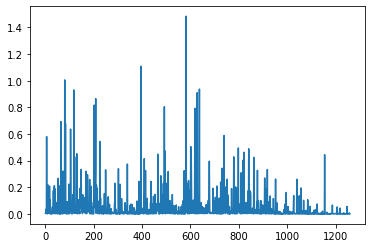

In [20]:
from tqdm import tqdm
from matplotlib import pyplot as plt
loss_fn = nn.CrossEntropyLoss()
loss_tracker = []
model = resnet_model
optim = torch.optim.Adam(model.parameters(),lr=0.001)
dml = "cuda:0"
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        
        input,target = input.to(device=dml),target.to(device = dml)
        input = input.reshape(-1,1,30,281)
        # calculate loss
        prediction = model(input)
        # class_probs = torch.argmax(prediction,dim=1)
        # print(prediction,target)
        loss = loss_fn(prediction, target)
        loss_tracker.append(loss.item())

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    

    print(f"loss: {loss.item()}")

optim = torch.optim.Adam(model.parameters(),lr=0.001)
def train(model, data_loader, loss_fn, optimiser, device, epochs):
    for i in tqdm(range(epochs)):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimiser, device)
        print("---------------------------")
    print("Finished training")
    plt.figure()
    plt.plot(loss_tracker)


train(model,train_dataloader,loss_fn,optim,dml,20)
torch.save(model.state_dict(),"resnet_20.pth")

In [31]:
def evaluate(model, test_dataloader, loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for input, target in test_dataloader:
            input = input.view(-1, 1, 30, 281).to(dml)
            target = target.to(device = dml)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            correct_predictions += torch.sum(predictions == target)
            total_predictions += target.shape[0]
            accuracy = correct_predictions / total_predictions
            loss = loss_fn(output, target)

            total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    print(f"Average test loss: {avg_loss}\t Accuracy: {accuracy}")

def test(model,data_loader, loss_fn):
    for epoch in tqdm(range(epochs)):
        evaluate(model, data_loader, loss_fn)
epochs = 10
model_to_eval = myresnet()
model_to_eval.load_state_dict(torch.load("resnet_5.pth"))
# print(model_to_eval)
test(model_to_eval,test_dataloader,loss_fn)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 10%|█         | 1/10 [00:05<00:51,  5.67s/it]

Average test loss: 1.2491567432880402	 Accuracy: 0.5674603581428528


 20%|██        | 2/10 [00:12<00:52,  6.62s/it]

Average test loss: 1.2522534132003784	 Accuracy: 0.5674603581428528


 30%|███       | 3/10 [00:18<00:43,  6.23s/it]

Average test loss: 1.252082645893097	 Accuracy: 0.5674603581428528


 40%|████      | 4/10 [00:25<00:38,  6.44s/it]

Average test loss: 1.2440303303301334	 Accuracy: 0.5674603581428528


 50%|█████     | 5/10 [00:31<00:32,  6.44s/it]

Average test loss: 1.2473426647484303	 Accuracy: 0.5674603581428528


 60%|██████    | 6/10 [00:37<00:24,  6.22s/it]

Average test loss: 1.2493424490094185	 Accuracy: 0.5674603581428528


 70%|███████   | 7/10 [00:44<00:19,  6.57s/it]

Average test loss: 1.2459064237773418	 Accuracy: 0.5674603581428528


 80%|████████  | 8/10 [00:50<00:12,  6.26s/it]

Average test loss: 1.2557206973433495	 Accuracy: 0.5674603581428528


 90%|█████████ | 9/10 [00:58<00:06,  6.70s/it]

Average test loss: 1.2552257664501667	 Accuracy: 0.5674603581428528


100%|██████████| 10/10 [01:04<00:00,  6.40s/it]

Average test loss: 1.2532929964363575	 Accuracy: 0.5674603581428528


In [32]:
def evaluate(model, test_dataloader, loss_fn):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for input, target in test_dataloader:
            input = input.view(-1, 1, 30, 281).to(dml)
            target = target.to(device = dml)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            correct_predictions += torch.sum(predictions == target)
            total_predictions += target.shape[0]
            accuracy = correct_predictions / total_predictions
            loss = loss_fn(output, target)

            total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    print(f"Average test loss: {avg_loss}\t Accuracy: {accuracy}")

def test(model,data_loader, loss_fn):
    for epoch in tqdm(range(epochs)):
        evaluate(model, data_loader, loss_fn)
epochs = 10
model_to_eval = myresnet()
model_to_eval.load_state_dict(torch.load("resnet_20.pth"))
# print(model_to_eval)
test(model_to_eval,test_dataloader,loss_fn)

 10%|█         | 1/10 [00:06<00:56,  6.31s/it]

Average test loss: 0.1367740045093342	 Accuracy: 0.9484127759933472


 20%|██        | 2/10 [00:13<00:56,  7.10s/it]

Average test loss: 0.1311714328639937	 Accuracy: 0.9484127759933472


 30%|███       | 3/10 [00:19<00:44,  6.38s/it]

Average test loss: 0.14270166047208477	 Accuracy: 0.9484127759933472


 40%|████      | 4/10 [00:26<00:40,  6.79s/it]

Average test loss: 0.13724502387049142	 Accuracy: 0.9484127759933472


 50%|█████     | 5/10 [00:32<00:31,  6.37s/it]

Average test loss: 0.13329648568287666	 Accuracy: 0.9484127759933472


 60%|██████    | 6/10 [00:40<00:27,  6.77s/it]

Average test loss: 0.13115523718079203	 Accuracy: 0.9484127759933472


 70%|███████   | 7/10 [00:45<00:19,  6.37s/it]

Average test loss: 0.13114656564357574	 Accuracy: 0.9484127759933472


 80%|████████  | 8/10 [00:52<00:13,  6.64s/it]

Average test loss: 0.13277183834361495	 Accuracy: 0.9484127759933472


 90%|█████████ | 9/10 [00:58<00:06,  6.43s/it]

Average test loss: 0.13392754450978828	 Accuracy: 0.9484127759933472


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]

Average test loss: 0.13189277059518645	 Accuracy: 0.9484127759933472
